<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Description" data-toc-modified-id="Data-Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Description</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Important-Scripts" data-toc-modified-id="Important-Scripts-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Important Scripts</a></span></li><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load the data</a></span></li><li><span><a href="#Log-transform-large-values" data-toc-modified-id="Log-transform-large-values-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Log transform large values</a></span></li><li><span><a href="#Train-Test-split-after-log-transform" data-toc-modified-id="Train-Test-split-after-log-transform-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Train-Test split after log transform</a></span></li><li><span><a href="#Scaling-the-Data" data-toc-modified-id="Scaling-the-Data-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Scaling the Data</a></span></li><li><span><a href="#GBR-Modelling" data-toc-modified-id="GBR-Modelling-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>GBR Modelling</a></span></li><li><span><a href="#GBR-modelling-using-pipeline" data-toc-modified-id="GBR-modelling-using-pipeline-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>GBR modelling using pipeline</a></span></li><li><span><a href="#Cross-Validation-Results" data-toc-modified-id="Cross-Validation-Results-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Cross Validation Results</a></span></li><li><span><a href="#HPO-(Hyper-Parameters-Optimization)" data-toc-modified-id="HPO-(Hyper-Parameters-Optimization)-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>HPO (Hyper Parameters Optimization)</a></span><ul class="toc-item"><li><span><a href="#Grid-Search-for-Gradient-Boosting-Regressor" data-toc-modified-id="Grid-Search-for-Gradient-Boosting-Regressor-11.1"><span class="toc-item-num">11.1&nbsp;&nbsp;</span>Grid Search for Gradient Boosting Regressor</a></span></li><li><span><a href="#Best-Model" data-toc-modified-id="Best-Model-11.2"><span class="toc-item-num">11.2&nbsp;&nbsp;</span>Best Model</a></span></li></ul></li></ul></div>

<div class="alert alert-block alert-success">
<b>Kernel Author:</b>  <br>
<a href="https://bhishanpdl.github.io/" , target="_blank">Bhishan Poudel,  Data Scientist, Ph.D Astrophysics</a> .
</div>

# Data Description

This dataset contains house sale prices for King County,
which includes Seattle.
It includes homes sold between May 2014 and May 2015.

- Dependent features: 1 (price)
- Features : 19 home features
- Id:  1 house ID

Task: Try to estimate the price based on given features.

![](https://github.com/bhishanpdl/Project_House_Price_Prediction/blob/master/data/raw/data_description.png?raw=1)

# Imports

In [1]:
import time
time_start_notebook = time.time()

In [2]:
%%capture
import os
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    ## install modules
    !pip install watermark
    !pip install featuretools

    # if we update existing module, we need to restart colab
    !pip install -U scikit-learn

    ## print
    print('Environment: Google Colaboratory.')
TREE_METHOD = 'gpu_hist' if ENV_COLAB else 'auto'

In [3]:
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
sns.set(color_codes=True)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# mixed
import os
import time
from pprint import pprint

# random state
SEED=100
np.random.seed(SEED)

# settings
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',200)
pd.set_option('display.max_colwidth',500)

# sklearn
import sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# boosting
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
import xgboost

# special
import featuretools
import featuretools as ft
from featuretools import variable_types as vtypes

# versions
import watermark
%load_ext watermark
%watermark -a "Bhishan Poudel" -d -v -m
print()
%watermark -iv

Bhishan Poudel 2020-11-13 

CPython 3.6.9
IPython 5.5.0

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.112+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit

featuretools 0.21.0
sklearn      0.23.2
seaborn      0.11.0
matplotlib   3.2.2
watermark    2.0.2
xgboost      0.90
pandas       1.1.4
numpy        1.18.5



# Important Scripts

In [4]:
def show_methods(obj, ncols=7,start=None, inside=None):
    """ Show all the attributes of a given method.
    Example:
    ========
    show_method_attributes(list)
     """

    print(f'Object Type: {type(obj)}\n')
    lst = [elem for elem in dir(obj) if elem[0]!='_' ]
    lst = [elem for elem in lst 
           if elem not in 'os np pd sys time psycopg2'.split() ]

    if isinstance(start,str):
        lst = [elem for elem in lst if elem.startswith(start)]
        
    if isinstance(start,tuple) or isinstance(start,list):
        lst = [elem for elem in lst for start_elem in start
               if elem.startswith(start_elem)]
        
    if isinstance(inside,str):
        lst = [elem for elem in lst if inside in elem]
        
    if isinstance(inside,tuple) or isinstance(inside,list):
        lst = [elem for elem in lst for inside_elem in inside
               if inside_elem in elem]

    return pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')

In [5]:
def adjustedR2(rsquared,nrows,ncols):
    return rsquared- (ncols-1)/(nrows-ncols) * (1-rsquared)

In [6]:
def print_regr_eval(ytest,ypreds,ncols):
    rmse = np.sqrt(metrics.mean_squared_error(ytest,ypreds))
    r2 = metrics.r2_score(ytest,ypreds)
    ar2 = adjustedR2(r2,len(ytest),ncols)
    evs = metrics.explained_variance_score(ytest, ypreds)

    print(f"""
             RMSE : {rmse:,.2f}
Explained Variance: {evs:.6f}
         R-Squared: {r2:,.6f}
Adjusted R-squared: {ar2:,.6f}

""")

In [7]:
def plot_xgb_cv_res(df_cv_results):
    fig,ax = plt.subplots()
    plt.plot(df_cv_results['train-rmse-mean'],color='b',label='train-rmse')
    plt.plot(df_cv_results['test-rmse-mean'],color='r',label='train-rmse')
    plt.title('Cross validation score mean plot',fontsize=14)
    plt.legend()
    plt.show()

# Parameters

In [8]:
if ENV_COLAB:
    path_raw = 'https://raw.githubusercontent.com/bhishanpdl/Datasets/master/'
    proj = 'Projects/King_County_Seattle_House_Price_Kaggle/'
    data_path_parent = path_raw + proj
    data_path_train = data_path_parent + 'raw/train.csv'
    data_path_test = data_path_parent + 'raw/test.csv'

else:
    data_path_parent = '../data/'
    data_path_train = data_path_parent + 'raw/train.csv'
    data_path_test = data_path_parent + 'raw/test.csv'

target = 'price'
train_size = 0.8

print(data_path_train)

https://raw.githubusercontent.com/bhishanpdl/Datasets/master/Projects/King_County_Seattle_House_Price_Kaggle/raw/train.csv


# Load the data

In [9]:
df_train = pd.read_csv(data_path_train)
df_test = pd.read_csv(data_path_test)
print(df_train.shape)
print(df_train.columns)

display(df_train.head(2).append(df_train.tail(2)))

(17290, 21)
Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2561340020,20140804T000000,325000.0,3,1.75,1780,11096,1.0,0,0,3,7,1210,570,1979,0,98074,47.6170,-122.051,1780,10640
1,8598200070,20141208T000000,278000.0,2,2.50,1420,2229,2.0,0,0,3,7,1420,0,2004,0,98059,47.4871,-122.165,1500,2230
17288,7174800760,20140725T000000,667000.0,5,2.00,1900,5470,1.0,0,0,3,7,1180,720,1930,1965,98105,47.6666,-122.303,1300,3250
17289,9521100280,20140612T000000,480000.0,3,2.50,1250,1103,3.0,0,2,3,8,1250,0,2005,0,98103,47.6619,-122.352,1250,1188


# Data Processing using featuretools
References
- https://www.kaggle.com/willkoehrsen/featuretools-for-good

## Remove target from train data

In [10]:
target = 'price'
ytrain = df_train.pop(target)
ytest = df_test.pop(target)

ytrain = np.array(ytrain).flatten()
ytest  = np.array(ytest).flatten()

ytrain[:5]

array([325000., 278000., 710000., 389900., 489000.])

In [11]:
features = list(df_train.columns)
features # there is 'index' but not the target 'price'

['id',
 'date',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [12]:
cols_drop = ['id']
try:
    df_train = df_train_raw.drop(cols_drop,axis=1)
    df_test = df_test_raw.drop(cols_drop,axis=1)
except:
    pass

## Data types
```python
from featuretools import variable_types as vtypes

Numeric Ordinal Categorical Datetime Boolean ZIPCode  Text TimeIndex URL
````

In [13]:
# df_train.head(2)

In [14]:
cols_int = ['bathrooms','floors']
for col in cols_int:
    df_train[col] = df_train[col].astype(np.int8)
    df_test[col] = df_test[col].astype(np.int8)

In [15]:
cols_date = ['date']
for col in cols_date:
    df_train[col] = pd.to_datetime(df_train[col])
    df_test[col] = pd.to_datetime(df_test[col])

In [16]:
df_train.head(2)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2561340020,2014-08-04,3,1,1780,11096,1,0,0,3,7,1210,570,1979,0,98074,47.6170,-122.051,1780,10640
1,8598200070,2014-12-08,2,2,1420,2229,2,0,0,3,7,1420,0,2004,0,98059,47.4871,-122.165,1500,2230


In [17]:
df_train.apply(pd.Series.nunique).sort_values()

waterfront           2
floors               3
condition            5
view                 5
bathrooms            9
grade               12
bedrooms            13
yr_renovated        66
zipcode             70
yr_built           116
sqft_basement      284
date               366
sqft_living15      713
long               735
sqft_above         844
sqft_living        927
lat               4832
sqft_lot15        7562
sqft_lot          8452
id               17182
dtype: int64

## Feature tools feature creation

In [18]:
ft.list_primitives().query("type=='transform'")['name'].to_numpy()

array(['cum_min', 'num_words', 'subtract_numeric', 'add_numeric',
       'cum_count', 'weekday', 'not_equal', 'or', 'year', 'equal',
       'modulo_by_feature', 'week', 'haversine', 'less_than_equal_to',
       'modulo_numeric', 'second', 'day', 'divide_numeric_scalar',
       'latitude', 'less_than', 'greater_than_equal_to',
       'multiply_boolean', 'not', 'time_since_previous', 'diff',
       'greater_than', 'is_null', 'multiply_numeric', 'cum_max',
       'subtract_numeric_scalar', 'time_since', 'add_numeric_scalar',
       'cum_mean', 'num_characters', 'scalar_subtract_numeric_feature',
       'cum_sum', 'is_weekend', 'not_equal_scalar', 'and', 'equal_scalar',
       'month', 'age', 'less_than_equal_to_scalar', 'minute',
       'modulo_numeric_scalar', 'divide_by_feature', 'hour',
       'less_than_scalar', 'longitude', 'divide_numeric',
       'greater_than_equal_to_scalar', 'percentile', 'absolute',
       'greater_than_scalar', 'multiply_numeric_scalar', 'negate', 'isin'],
   

In [19]:
# data types
cols_types = [
    (['bathrooms','bedrooms','floors'], vtypes.Ordinal),
    (['condition','grade','view'], vtypes.Categorical),
    (['date'], vtypes.Datetime),
    (['zipcode'], vtypes.ZIPCode),
    (['waterfront'], vtypes.Boolean),
    (['index'], vtypes.Index),
    (['lat','long','sqft_above','sqft_basement',
        'sqft_living','sqft_living15','sqft_lot',
        'yr_built','yr_renovated'], vtypes.Numeric)
]


var_types = dict()
for cols, dtype in cols_types:
    for col in cols:
        var_types[col]= dtype

# var_types

In [20]:
# variable types
# keep bathrooms bedrooms etc numeric
# we dont need to define type of numeric variable
var_types = {
    'date': vtypes.Datetime,
    'index': vtypes.Index,
    'waterfront': vtypes.Boolean,
    'zipcode': vtypes.ZIPCode
 }


# Here index for all rows is unique, if we do aggregation
# e.g. min max, we get the same number for all (this is simply a bias term)
# So, we don't need agg primitives here.
agg_primitives = []

trans_primitives = [
    'divide_numeric', # cross multiply all numeric features (not others)
    'multiply_numeric',
    #'Year' # get year from 'date' feature. do not use year, i will create it later
    ]

cols_exclude = ['lat','long'] # the division does not make sense for lat lon

In [21]:
def get_extra_features_from_ft(dfx,var_types=var_types,
                               agg_primitives=agg_primitives,
                               trans_primitives=trans_primitives,
                               features=features,
                               targetname='price',
                               cols_exclude=cols_exclude,
                               ):

    if cols_exclude:
        dfx = dfx.drop(cols_exclude,axis=1)
    
    var_types = {k:v for k,v in var_types.items() if k not in cols_exclude}

    makeindex = False if 'index' in dfx.columns else True
    es = ft.EntitySet("houses")
    es.entity_from_dataframe(entity_id="data",
                         dataframe=dfx,
                         make_index=makeindex,
                         index='index',
                         time_index='date',
                         variable_types=var_types)

    cutoff_time = es['data'].df[['index', 'date']]
    es.add_interesting_values()

    # additional features added
    feature_matrix_extra, feature_defs_extra = ft.dfs(entityset=es,
                            target_entity='data',
                            agg_primitives=agg_primitives,
                            trans_primitives=trans_primitives,
                            drop_contains=[],
                            drop_exact=list(features)+[targetname],
                            cutoff_time=cutoff_time,
                            max_depth=2,
                            n_jobs=-1,
                            max_features=1000,
                            chunk_size=1000,
                            verbose=True,
                            )
    
    return feature_matrix_extra

In [22]:
df_train_extra = get_extra_features_from_ft(df_train)
df_train_extra.head(2)

Built 315 features
EntitySet scattered to 2 workers in 2 seconds
Elapsed: 01:30 | Progress: 100%|██████████


,bathrooms / bedrooms,bathrooms / condition,bathrooms / floors,bathrooms / grade,bathrooms / id,bathrooms / sqft_above,bathrooms / sqft_basement,bathrooms / sqft_living,bathrooms / sqft_living15,bathrooms / sqft_lot,bathrooms / sqft_lot15,bathrooms / view,bathrooms / yr_built,bathrooms / yr_renovated,bedrooms / bathrooms,bedrooms / condition,bedrooms / floors,bedrooms / grade,bedrooms / id,bedrooms / sqft_above,bedrooms / sqft_basement,bedrooms / sqft_living,bedrooms / sqft_living15,bedrooms / sqft_lot,bedrooms / sqft_lot15,bedrooms / view,bedrooms / yr_built,bedrooms / yr_renovated,condition / bathrooms,condition / bedrooms,condition / floors,condition / grade,condition / id,condition / sqft_above,condition / sqft_basement,condition / sqft_living,condition / sqft_living15,condition / sqft_lot,condition / sqft_lot15,condition / view,condition / yr_built,condition / yr_renovated,floors / bathrooms,floors / bedrooms,floors / condition,floors / grade,floors / id,floors / sqft_above,floors / sqft_basement,floors / sqft_living,floors / sqft_living15,floors / sqft_lot,floors / sqft_lot15,floors / view,floors / yr_built,floors / yr_renovated,grade / bathrooms,grade / bedrooms,grade / condition,grade / floors,grade / id,grade / sqft_above,grade / sqft_basement,grade / sqft_living,grade / sqft_living15,grade / sqft_lot,grade / sqft_lot15,grade / view,grade / yr_built,grade / yr_renovated,id / bathrooms,id / bedrooms,id / condition,id / floors,id / grade,id / sqft_above,id / sqft_basement,id / sqft_living,id / sqft_living15,id / sqft_lot,id / sqft_lot15,id / view,id / yr_built,id / yr_renovated,sqft_above / bathrooms,sqft_above / bedrooms,sqft_above / condition,sqft_above / floors,sqft_above / grade,sqft_above / id,sqft_above / sqft_basement,sqft_above / sqft_living,sqft_above / sqft_living15,sqft_above / sqft_lot,sqft_above / sqft_lot15,sqft_above / view,sqft_above / yr_built,sqft_above / yr_renovated,sqft_basement / bathrooms,sqft_basement / bedrooms,sqft_basement / condition,sqft_basement / floors,sqft_basement / grade,sqft_basement / id,sqft_basement / sqft_above,sqft_basement / sqft_living,sqft_basement / sqft_living15,sqft_basement / sqft_lot,sqft_basement / sqft_lot15,sqft_basement / view,sqft_basement / yr_built,sqft_basement / yr_renovated,sqft_living / bathrooms,sqft_living / bedrooms,sqft_living / condition,sqft_living / floors,sqft_living / grade,sqft_living / id,sqft_living / sqft_above,sqft_living / sqft_basement,sqft_living / sqft_living15,sqft_living / sqft_lot,sqft_living / sqft_lot15,sqft_living / view,sqft_living / yr_built,sqft_living / yr_renovated,sqft_living15 / bathrooms,sqft_living15 / bedrooms,sqft_living15 / condition,sqft_living15 / floors,sqft_living15 / grade,sqft_living15 / id,sqft_living15 / sqft_above,sqft_living15 / sqft_basement,sqft_living15 / sqft_living,sqft_living15 / sqft_lot,sqft_living15 / sqft_lot15,sqft_living15 / view,sqft_living15 / yr_built,sqft_living15 / yr_renovated,sqft_lot / bathrooms,sqft_lot / bedrooms,sqft_lot / condition,sqft_lot / floors,sqft_lot / grade,sqft_lot / id,sqft_lot / sqft_above,sqft_lot / sqft_basement,sqft_lot / sqft_living,sqft_lot / sqft_living15,sqft_lot / sqft_lot15,sqft_lot / view,sqft_lot / yr_built,sqft_lot / yr_renovated,sqft_lot15 / bathrooms,sqft_lot15 / bedrooms,sqft_lot15 / condition,sqft_lot15 / floors,sqft_lot15 / grade,sqft_lot15 / id,sqft_lot15 / sqft_above,sqft_lot15 / sqft_basement,sqft_lot15 / sqft_living,sqft_lot15 / sqft_living15,sqft_lot15 / sqft_lot,sqft_lot15 / view,sqft_lot15 / yr_built,sqft_lot15 / yr_renovated,view / bathrooms,view / bedrooms,view / condition,view / floors,view / grade,view / id,view / sqft_above,view / sqft_basement,view / sqft_living,view / sqft_living15,view / sqft_lot,view / sqft_lot15,view / yr_built,view / yr_renovated,yr_built / bathrooms,yr_built / bedrooms,yr_built / condition,yr_built / floors,yr_built / grade,yr_built / id,yr_built / sqft_above,yr_built / sqft_basement,yr_built / sqft_living,yr_built / sqft_living

In [23]:
df_test_extra = get_extra_features_from_ft(df_test)
df_test_extra.head(2)

Built 315 features
EntitySet scattered to 2 workers in 2 seconds
Elapsed: 01:19 | Progress: 100%|██████████


,bathrooms / bedrooms,bathrooms / condition,bathrooms / floors,bathrooms / grade,bathrooms / id,bathrooms / sqft_above,bathrooms / sqft_basement,bathrooms / sqft_living,bathrooms / sqft_living15,bathrooms / sqft_lot,bathrooms / sqft_lot15,bathrooms / view,bathrooms / yr_built,bathrooms / yr_renovated,bedrooms / bathrooms,bedrooms / condition,bedrooms / floors,bedrooms / grade,bedrooms / id,bedrooms / sqft_above,bedrooms / sqft_basement,bedrooms / sqft_living,bedrooms / sqft_living15,bedrooms / sqft_lot,bedrooms / sqft_lot15,bedrooms / view,bedrooms / yr_built,bedrooms / yr_renovated,condition / bathrooms,condition / bedrooms,condition / floors,condition / grade,condition / id,condition / sqft_above,condition / sqft_basement,condition / sqft_living,condition / sqft_living15,condition / sqft_lot,condition / sqft_lot15,condition / view,condition / yr_built,condition / yr_renovated,floors / bathrooms,floors / bedrooms,floors / condition,floors / grade,floors / id,floors / sqft_above,floors / sqft_basement,floors / sqft_living,floors / sqft_living15,floors / sqft_lot,floors / sqft_lot15,floors / view,floors / yr_built,floors / yr_renovated,grade / bathrooms,grade / bedrooms,grade / condition,grade / floors,grade / id,grade / sqft_above,grade / sqft_basement,grade / sqft_living,grade / sqft_living15,grade / sqft_lot,grade / sqft_lot15,grade / view,grade / yr_built,grade / yr_renovated,id / bathrooms,id / bedrooms,id / condition,id / floors,id / grade,id / sqft_above,id / sqft_basement,id / sqft_living,id / sqft_living15,id / sqft_lot,id / sqft_lot15,id / view,id / yr_built,id / yr_renovated,sqft_above / bathrooms,sqft_above / bedrooms,sqft_above / condition,sqft_above / floors,sqft_above / grade,sqft_above / id,sqft_above / sqft_basement,sqft_above / sqft_living,sqft_above / sqft_living15,sqft_above / sqft_lot,sqft_above / sqft_lot15,sqft_above / view,sqft_above / yr_built,sqft_above / yr_renovated,sqft_basement / bathrooms,sqft_basement / bedrooms,sqft_basement / condition,sqft_basement / floors,sqft_basement / grade,sqft_basement / id,sqft_basement / sqft_above,sqft_basement / sqft_living,sqft_basement / sqft_living15,sqft_basement / sqft_lot,sqft_basement / sqft_lot15,sqft_basement / view,sqft_basement / yr_built,sqft_basement / yr_renovated,sqft_living / bathrooms,sqft_living / bedrooms,sqft_living / condition,sqft_living / floors,sqft_living / grade,sqft_living / id,sqft_living / sqft_above,sqft_living / sqft_basement,sqft_living / sqft_living15,sqft_living / sqft_lot,sqft_living / sqft_lot15,sqft_living / view,sqft_living / yr_built,sqft_living / yr_renovated,sqft_living15 / bathrooms,sqft_living15 / bedrooms,sqft_living15 / condition,sqft_living15 / floors,sqft_living15 / grade,sqft_living15 / id,sqft_living15 / sqft_above,sqft_living15 / sqft_basement,sqft_living15 / sqft_living,sqft_living15 / sqft_lot,sqft_living15 / sqft_lot15,sqft_living15 / view,sqft_living15 / yr_built,sqft_living15 / yr_renovated,sqft_lot / bathrooms,sqft_lot / bedrooms,sqft_lot / condition,sqft_lot / floors,sqft_lot / grade,sqft_lot / id,sqft_lot / sqft_above,sqft_lot / sqft_basement,sqft_lot / sqft_living,sqft_lot / sqft_living15,sqft_lot / sqft_lot15,sqft_lot / view,sqft_lot / yr_built,sqft_lot / yr_renovated,sqft_lot15 / bathrooms,sqft_lot15 / bedrooms,sqft_lot15 / condition,sqft_lot15 / floors,sqft_lot15 / grade,sqft_lot15 / id,sqft_lot15 / sqft_above,sqft_lot15 / sqft_basement,sqft_lot15 / sqft_living,sqft_lot15 / sqft_living15,sqft_lot15 / sqft_lot,sqft_lot15 / view,sqft_lot15 / yr_built,sqft_lot15 / yr_renovated,view / bathrooms,view / bedrooms,view / condition,view / floors,view / grade,view / id,view / sqft_above,view / sqft_basement,view / sqft_living,view / sqft_living15,view / sqft_lot,view / sqft_lot15,view / yr_built,view / yr_renovated,yr_built / bathrooms,yr_built / bedrooms,yr_built / condition,yr_built / floors,yr_built / grade,yr_built / id,yr_built / sqft_above,yr_built / sqft_basement,yr_built / sqft_living,yr_built / sqft_living

## Post process feature matrix

In [24]:
def post_process_fm(fm,thr_miss=0.95,thr_corr=0.95):
    """Post process feature matrix.
    1. remove duplicated features
    2. remove features having many missing features
    3. remvoe zero variance features
    4. remove high collinear features

    """
    # Remove duplicated features
    start_features = fm.shape[1]
    fm = fm.iloc[:, ~fm.columns.duplicated()]
    n_dups = start_features - fm.shape[1]
    print(f'There were {n_dups} duplicated features.')
    fm = fm.replace({np.inf: np.nan, -np.inf:np.nan})

    # Remove the ids and labels
    idname = 'index'
    targetname = 'price'
    cols_drop_id = [ i for i in fm.columns if idname in i]
    cols_drop_target = [ i for i in fm.columns if targetname in i]
    cols_drop_id_target = cols_drop_id + cols_drop_target

    print('Dropping ids and label: ', cols_drop_id_target)
    fm = fm.drop(cols_drop_id_target,axis=1)

    # One hot encoding (if necessary)
    fm = pd.get_dummies(fm)
    n_features_start = fm.shape[1]
    print('Original shape: ', fm.shape)
    
    # Find missing and percentage
    df_miss = pd.DataFrame(fm.isnull().sum())
    df_miss['frac'] = df_miss[0] / fm.shape[0]
    df_miss.sort_values('frac', ascending = False, inplace = True)

    # Missing above threshold
    cols_miss = list(df_miss[df_miss['frac'] > thr_miss].index)
    n_cols_miss = len(cols_miss)

    # Remove missing columns
    fm = fm[[i for i in fm if i not in cols_miss]]
    print('{} missing columns with threshold: {}.'.format(
        n_cols_miss, thr_miss))
    
    # Zero variance
    df_unq_ct = pd.DataFrame(fm.nunique()).sort_values(0,ascending=True)
    cols_zero_var = list(df_unq_ct[df_unq_ct[0] == 1].index)
    n_cols_zero_var = len(cols_zero_var)

    # Remove zero variance columns
    fm = fm[[i for i in fm if i not in cols_zero_var]]
    print('{} zero variance columns.'.format(n_cols_zero_var))
    
    # Correlations
    df_corr = fm.corr()

    # Extract the upper triangle of the correlation matrix
    df_upper = df_corr.where(np.triu(np.ones(df_corr.shape), k = 1).astype(np.bool))

    # Select the features with correlations above the threshold
    # Need to use the absolute value
    cols_drop = [col for col in df_upper.columns 
                    if any(df_upper[col].abs() > thr_corr)]

    n_collinear = len(cols_drop)

    fm = fm[[i for i in fm if i not in cols_drop]]
    print('{} collinear columns removed with correlation above {}.'.format(
        n_collinear,  thr_corr))

    n_total_cols_removed = n_dups + n_cols_miss + n_cols_zero_var + n_collinear

    print('Total columns removed: ', n_total_cols_removed)
    print('Shape after feature selection: {}.'.format(fm.shape))

    return fm

In [25]:
df_train_extra = post_process_fm(df_train_extra)
df_train_extra.head(2)

There were 0 duplicated features.
Dropping ids and label:  []
Original shape:  (17290, 315)
14 missing columns with threshold: 0.95.
0 zero variance columns.
90 collinear columns removed with correlation above 0.95.
Total columns removed:  104
Shape after feature selection: (17290, 211).


,bathrooms / bedrooms,bathrooms / condition,bathrooms / floors,bathrooms / grade,bathrooms / id,bathrooms / sqft_above,bathrooms / sqft_basement,bathrooms / sqft_living,bathrooms / sqft_living15,bathrooms / sqft_lot,bathrooms / sqft_lot15,bathrooms / view,bathrooms / yr_built,bedrooms / bathrooms,bedrooms / condition,bedrooms / floors,bedrooms / grade,bedrooms / sqft_above,bedrooms / sqft_basement,bedrooms / sqft_living,bedrooms / sqft_living15,bedrooms / sqft_lot,bedrooms / sqft_lot15,bedrooms / view,bedrooms / yr_built,condition / bathrooms,condition / bedrooms,condition / floors,condition / grade,condition / id,condition / sqft_above,condition / sqft_basement,condition / sqft_living,condition / sqft_living15,condition / sqft_lot,condition / sqft_lot15,condition / view,condition / yr_built,floors / bathrooms,floors / bedrooms,floors / condition,floors / grade,floors / sqft_above,floors / sqft_basement,floors / sqft_living,floors / sqft_living15,floors / sqft_lot,floors / sqft_lot15,floors / view,floors / yr_built,grade / bathrooms,grade / bedrooms,grade / condition,grade / floors,grade / sqft_above,grade / sqft_living,grade / sqft_living15,grade / view,grade / yr_built,id / bathrooms,id / bedrooms,id / condition,id / floors,id / grade,id / sqft_above,id / sqft_basement,id / sqft_living,id / sqft_living15,id / sqft_lot,id / sqft_lot15,id / view,sqft_above / bathrooms,sqft_above / bedrooms,sqft_above / condition,sqft_above / floors,sqft_above / grade,sqft_above / sqft_basement,sqft_above / sqft_living,sqft_above / sqft_living15,sqft_above / sqft_lot,sqft_above / sqft_lot15,sqft_above / view,sqft_above / yr_built,sqft_basement / bathrooms,sqft_basement / bedrooms,sqft_basement / condition,sqft_basement / floors,sqft_basement / id,sqft_basement / sqft_lot,sqft_basement / sqft_lot15,sqft_basement / view,sqft_living / bathrooms,sqft_living / bedrooms,sqft_living / condition,sqft_living / floors,sqft_living / grade,sqft_living / sqft_living15,sqft_living / view,sqft_living / yr_built,sqft_living15 / bathrooms,sqft_living15 / bedrooms,sqft_living15 / condition,sqft_living15 / floors,sqft_living15 / grade,sqft_living15 / sqft_above,sqft_living15 / sqft_basement,sqft_living15 / sqft_living,sqft_living15 / sqft_lot,sqft_living15 / sqft_lot15,sqft_living15 / view,sqft_living15 / yr_built,sqft_lot / bathrooms,sqft_lot / bedrooms,sqft_lot / condition,sqft_lot / floors,sqft_lot / id,sqft_lot / sqft_above,sqft_lot / sqft_basement,sqft_lot / sqft_lot15,sqft_lot15 / bathrooms,sqft_lot15 / bedrooms,sqft_lot15 / condition,sqft_lot15 / floors,sqft_lot15 / sqft_above,sqft_lot15 / sqft_basement,sqft_lot15 / sqft_living15,sqft_lot15 / sqft_lot,sqft_lot15 / view,view / bathrooms,view / bedrooms,view / condition,view / floors,view / id,view / sqft_above,view / sqft_basement,view / sqft_lot,view / sqft_lot15,yr_built / bathrooms,yr_built / bedrooms,yr_built / condition,yr_built / grade,yr_built / sqft_above,yr_built / sqft_living,yr_built / sqft_living15,yr_built / view,yr_renovated / bathrooms,yr_renovated / bedrooms,yr_renovated / condition,yr_renovated / floors,yr_renovated / id,yr_renovated / sqft_above,yr_renovated / sqft_basement,yr_renovated / sqft_lot,yr_renovated / sqft_lot15,yr_renovated / view,bathrooms * bedrooms,bathrooms * condition,bathrooms * floors,bathrooms * id,bathrooms * sqft_above,bathrooms * sqft_basement,bathrooms * sqft_living15,bathrooms * sqft_lot,bathrooms * sqft_lot15,bathrooms * view,bathrooms * yr_renovated,bedrooms * condition,bedrooms * floors,bedrooms * grade,bedrooms * id,bedrooms * sqft_above,bedrooms * sqft_living,bedrooms * sqft_living15,condition * floors,condition * grade,condition * id,condition * sqft_above,condition * sqft_living,condition * sqft_living15,floors * grade,floors * id,floors * sqft_above,floors * sqft_basement,floors * sqft_living15,floors * sqft_lot,floors * sqft_lot15,floors * view,floors * yr_renovated,id * sqft_above,id * sqft_basement,id * sqft_living,id * sqft_living15,id * sqft_lot,id * s

In [26]:
df_test_extra = post_process_fm(df_test_extra)
df_test_extra.head(2)

There were 0 duplicated features.
Dropping ids and label:  []
Original shape:  (4323, 315)
14 missing columns with threshold: 0.95.
0 zero variance columns.
94 collinear columns removed with correlation above 0.95.
Total columns removed:  108
Shape after feature selection: (4323, 207).


,bathrooms / bedrooms,bathrooms / condition,bathrooms / floors,bathrooms / grade,bathrooms / id,bathrooms / sqft_above,bathrooms / sqft_basement,bathrooms / sqft_living,bathrooms / sqft_living15,bathrooms / sqft_lot,bathrooms / sqft_lot15,bathrooms / view,bathrooms / yr_built,bedrooms / bathrooms,bedrooms / condition,bedrooms / floors,bedrooms / grade,bedrooms / sqft_above,bedrooms / sqft_basement,bedrooms / sqft_living,bedrooms / sqft_living15,bedrooms / sqft_lot,bedrooms / sqft_lot15,bedrooms / view,bedrooms / yr_built,condition / bathrooms,condition / bedrooms,condition / floors,condition / grade,condition / sqft_above,condition / sqft_basement,condition / sqft_living,condition / sqft_living15,condition / sqft_lot,condition / sqft_lot15,condition / view,condition / yr_built,floors / bathrooms,floors / bedrooms,floors / condition,floors / grade,floors / sqft_above,floors / sqft_living,floors / sqft_living15,floors / sqft_lot,floors / sqft_lot15,floors / view,floors / yr_built,grade / bathrooms,grade / bedrooms,grade / condition,grade / sqft_above,grade / sqft_living,grade / sqft_living15,grade / view,grade / yr_built,id / bathrooms,id / bedrooms,id / condition,id / floors,id / grade,id / sqft_above,id / sqft_basement,id / sqft_living,id / sqft_living15,id / sqft_lot,id / sqft_lot15,id / view,sqft_above / bathrooms,sqft_above / bedrooms,sqft_above / condition,sqft_above / floors,sqft_above / grade,sqft_above / sqft_basement,sqft_above / sqft_living,sqft_above / sqft_living15,sqft_above / sqft_lot,sqft_above / sqft_lot15,sqft_above / view,sqft_above / yr_built,sqft_basement / bathrooms,sqft_basement / bedrooms,sqft_basement / condition,sqft_basement / floors,sqft_basement / id,sqft_basement / sqft_lot,sqft_basement / sqft_lot15,sqft_basement / view,sqft_living / bathrooms,sqft_living / bedrooms,sqft_living / condition,sqft_living / floors,sqft_living / grade,sqft_living / sqft_living15,sqft_living / view,sqft_living / yr_built,sqft_living15 / bathrooms,sqft_living15 / bedrooms,sqft_living15 / condition,sqft_living15 / floors,sqft_living15 / grade,sqft_living15 / sqft_above,sqft_living15 / sqft_living,sqft_living15 / sqft_lot,sqft_living15 / sqft_lot15,sqft_living15 / view,sqft_living15 / yr_built,sqft_lot / bathrooms,sqft_lot / bedrooms,sqft_lot / condition,sqft_lot / floors,sqft_lot / id,sqft_lot / sqft_above,sqft_lot / sqft_basement,sqft_lot / sqft_living15,sqft_lot / sqft_lot15,sqft_lot15 / bathrooms,sqft_lot15 / bedrooms,sqft_lot15 / condition,sqft_lot15 / floors,sqft_lot15 / sqft_above,sqft_lot15 / sqft_basement,sqft_lot15 / sqft_lot,sqft_lot15 / view,view / bathrooms,view / bedrooms,view / condition,view / floors,view / id,view / sqft_above,view / sqft_basement,view / sqft_lot,view / sqft_lot15,yr_built / bathrooms,yr_built / bedrooms,yr_built / condition,yr_built / sqft_living15,yr_built / view,yr_renovated / bathrooms,yr_renovated / bedrooms,yr_renovated / condition,yr_renovated / floors,yr_renovated / id,yr_renovated / sqft_above,yr_renovated / sqft_basement,yr_renovated / sqft_lot,yr_renovated / sqft_lot15,yr_renovated / view,bathrooms * bedrooms,bathrooms * condition,bathrooms * floors,bathrooms * id,bathrooms * sqft_above,bathrooms * sqft_basement,bathrooms * sqft_living15,bathrooms * sqft_lot,bathrooms * sqft_lot15,bathrooms * view,bathrooms * yr_renovated,bedrooms * condition,bedrooms * floors,bedrooms * grade,bedrooms * id,bedrooms * sqft_above,bedrooms * sqft_living,bedrooms * sqft_living15,bedrooms * sqft_lot,bedrooms * yr_renovated,condition * floors,condition * grade,condition * id,condition * sqft_above,condition * sqft_living,condition * sqft_living15,floors * grade,floors * id,floors * sqft_above,floors * sqft_basement,floors * sqft_living15,floors * sqft_lot,floors * sqft_lot15,floors * view,floors * yr_renovated,id * sqft_above,id * sqft_basement,id * sqft_living,id * sqft_living15,id * sqft_lot,id * sqft_lot15,id * view,id * yr_renovated,sqft_above * sqft_basement,sqft_above * sqft_living,sqft_above * 

In [27]:
features_extra = [ i for i in df_train_extra.columns if i in df_test_extra.columns]
print(features_extra)

['bathrooms / bedrooms', 'bathrooms / condition', 'bathrooms / floors', 'bathrooms / grade', 'bathrooms / id', 'bathrooms / sqft_above', 'bathrooms / sqft_basement', 'bathrooms / sqft_living', 'bathrooms / sqft_living15', 'bathrooms / sqft_lot', 'bathrooms / sqft_lot15', 'bathrooms / view', 'bathrooms / yr_built', 'bedrooms / bathrooms', 'bedrooms / condition', 'bedrooms / floors', 'bedrooms / grade', 'bedrooms / sqft_above', 'bedrooms / sqft_basement', 'bedrooms / sqft_living', 'bedrooms / sqft_living15', 'bedrooms / sqft_lot', 'bedrooms / sqft_lot15', 'bedrooms / view', 'bedrooms / yr_built', 'condition / bathrooms', 'condition / bedrooms', 'condition / floors', 'condition / grade', 'condition / sqft_above', 'condition / sqft_basement', 'condition / sqft_living', 'condition / sqft_living15', 'condition / sqft_lot', 'condition / sqft_lot15', 'condition / view', 'condition / yr_built', 'floors / bathrooms', 'floors / bedrooms', 'floors / condition', 'floors / grade', 'floors / sqft_abo

## Impute extra features

In [28]:
df_train_extra.isna().sum().sum()

319676

In [29]:
df_train_extra = df_train_extra.fillna(0.0)
df_test_extra = df_test_extra.fillna(0.0)

## combine extra features

In [30]:
df_train = pd.concat([df_train,df_train_extra],axis=1)
df_test = pd.concat([df_test, df_test_extra],axis=1)

df_train.head(2)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bathrooms / bedrooms,bathrooms / condition,bathrooms / floors,bathrooms / grade,bathrooms / id,bathrooms / sqft_above,bathrooms / sqft_basement,bathrooms / sqft_living,bathrooms / sqft_living15,bathrooms / sqft_lot,bathrooms / sqft_lot15,bathrooms / view,bathrooms / yr_built,bedrooms / bathrooms,bedrooms / condition,bedrooms / floors,bedrooms / grade,bedrooms / sqft_above,bedrooms / sqft_basement,bedrooms / sqft_living,bedrooms / sqft_living15,bedrooms / sqft_lot,bedrooms / sqft_lot15,bedrooms / view,bedrooms / yr_built,condition / bathrooms,condition / bedrooms,condition / floors,condition / grade,condition / id,condition / sqft_above,condition / sqft_basement,condition / sqft_living,condition / sqft_living15,condition / sqft_lot,condition / sqft_lot15,condition / view,condition / yr_built,floors / bathrooms,floors / bedrooms,floors / condition,floors / grade,floors / sqft_above,floors / sqft_basement,floors / sqft_living,floors / sqft_living15,floors / sqft_lot,floors / sqft_lot15,floors / view,floors / yr_built,grade / bathrooms,grade / bedrooms,grade / condition,grade / floors,grade / sqft_above,grade / sqft_living,grade / sqft_living15,grade / view,grade / yr_built,id / bathrooms,id / bedrooms,id / condition,id / floors,id / grade,id / sqft_above,id / sqft_basement,id / sqft_living,id / sqft_living15,id / sqft_lot,id / sqft_lot15,id / view,sqft_above / bathrooms,sqft_above / bedrooms,sqft_above / condition,sqft_above / floors,sqft_above / grade,sqft_above / sqft_basement,sqft_above / sqft_living,sqft_above / sqft_living15,sqft_above / sqft_lot,sqft_above / sqft_lot15,sqft_above / view,sqft_above / yr_built,sqft_basement / bathrooms,sqft_basement / bedrooms,sqft_basement / condition,sqft_basement / floors,sqft_basement / id,sqft_basement / sqft_lot,sqft_basement / sqft_lot15,sqft_basement / view,sqft_living / bathrooms,sqft_living / bedrooms,sqft_living / condition,sqft_living / floors,sqft_living / grade,sqft_living / sqft_living15,sqft_living / view,sqft_living / yr_built,sqft_living15 / bathrooms,sqft_living15 / bedrooms,sqft_living15 / condition,sqft_living15 / floors,sqft_living15 / grade,sqft_living15 / sqft_above,sqft_living15 / sqft_basement,sqft_living15 / sqft_living,sqft_living15 / sqft_lot,sqft_living15 / sqft_lot15,sqft_living15 / view,sqft_living15 / yr_built,sqft_lot / bathrooms,sqft_lot / bedrooms,sqft_lot / condition,sqft_lot / floors,sqft_lot / id,sqft_lot / sqft_above,sqft_lot / sqft_basement,sqft_lot / sqft_lot15,sqft_lot15 / bathrooms,sqft_lot15 / bedrooms,sqft_lot15 / condition,sqft_lot15 / floors,sqft_lot15 / sqft_above,sqft_lot15 / sqft_basement,sqft_lot15 / sqft_living15,sqft_lot15 / sqft_lot,sqft_lot15 / view,view / bathrooms,view / bedrooms,view / condition,view / floors,view / id,view / sqft_above,view / sqft_basement,view / sqft_lot,view / sqft_lot15,yr_built / bathrooms,yr_built / bedrooms,yr_built / condition,yr_built / grade,yr_built / sqft_above,yr_built / sqft_living,yr_built / sqft_living15,yr_built / view,yr_renovated / bathrooms,yr_renovated / bedrooms,yr_renovated / condition,yr_renovated / floors,yr_renovated / id,yr_renovated / sqft_above,yr_renovated / sqft_basement,yr_renovated / sqft_lot,yr_renovated / sqft_lot15,yr_renovated / view,bathrooms * bedrooms,bathrooms * condition,bathrooms * floors,bathrooms * id,bathrooms * sqft_above,bathrooms * sqft_basement,bathrooms * sqft_living15,bathrooms * sqft_lot,bathrooms * sqft_lot15,bathrooms * view,bathrooms * yr_renovated,bedrooms * condition,bedrooms * floors,bedrooms * grade,bedrooms * id,bedrooms * sqft_above,bedrooms * sqft_living,bedrooms * sqft_living15,condition * floors,condition * grade,condition * id,condition * sqft_above,condition * sqft_living,condition * sqft_living15,floors * grade,floors * id,floors * sqft_above,floors * sqft_basement,floors * sqf

In [31]:
df_test.head(2)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,bathrooms / bedrooms,bathrooms / condition,bathrooms / floors,bathrooms / grade,bathrooms / id,bathrooms / sqft_above,bathrooms / sqft_basement,bathrooms / sqft_living,bathrooms / sqft_living15,bathrooms / sqft_lot,bathrooms / sqft_lot15,bathrooms / view,bathrooms / yr_built,bedrooms / bathrooms,bedrooms / condition,bedrooms / floors,bedrooms / grade,bedrooms / sqft_above,bedrooms / sqft_basement,bedrooms / sqft_living,bedrooms / sqft_living15,bedrooms / sqft_lot,bedrooms / sqft_lot15,bedrooms / view,bedrooms / yr_built,condition / bathrooms,condition / bedrooms,condition / floors,condition / grade,condition / sqft_above,condition / sqft_basement,condition / sqft_living,condition / sqft_living15,condition / sqft_lot,condition / sqft_lot15,condition / view,condition / yr_built,floors / bathrooms,floors / bedrooms,floors / condition,floors / grade,floors / sqft_above,floors / sqft_living,floors / sqft_living15,floors / sqft_lot,floors / sqft_lot15,floors / view,floors / yr_built,grade / bathrooms,grade / bedrooms,grade / condition,grade / sqft_above,grade / sqft_living,grade / sqft_living15,grade / view,grade / yr_built,id / bathrooms,id / bedrooms,id / condition,id / floors,id / grade,id / sqft_above,id / sqft_basement,id / sqft_living,id / sqft_living15,id / sqft_lot,id / sqft_lot15,id / view,sqft_above / bathrooms,sqft_above / bedrooms,sqft_above / condition,sqft_above / floors,sqft_above / grade,sqft_above / sqft_basement,sqft_above / sqft_living,sqft_above / sqft_living15,sqft_above / sqft_lot,sqft_above / sqft_lot15,sqft_above / view,sqft_above / yr_built,sqft_basement / bathrooms,sqft_basement / bedrooms,sqft_basement / condition,sqft_basement / floors,sqft_basement / id,sqft_basement / sqft_lot,sqft_basement / sqft_lot15,sqft_basement / view,sqft_living / bathrooms,sqft_living / bedrooms,sqft_living / condition,sqft_living / floors,sqft_living / grade,sqft_living / sqft_living15,sqft_living / view,sqft_living / yr_built,sqft_living15 / bathrooms,sqft_living15 / bedrooms,sqft_living15 / condition,sqft_living15 / floors,sqft_living15 / grade,sqft_living15 / sqft_above,sqft_living15 / sqft_living,sqft_living15 / sqft_lot,sqft_living15 / sqft_lot15,sqft_living15 / view,sqft_living15 / yr_built,sqft_lot / bathrooms,sqft_lot / bedrooms,sqft_lot / condition,sqft_lot / floors,sqft_lot / id,sqft_lot / sqft_above,sqft_lot / sqft_basement,sqft_lot / sqft_living15,sqft_lot / sqft_lot15,sqft_lot15 / bathrooms,sqft_lot15 / bedrooms,sqft_lot15 / condition,sqft_lot15 / floors,sqft_lot15 / sqft_above,sqft_lot15 / sqft_basement,sqft_lot15 / sqft_lot,sqft_lot15 / view,view / bathrooms,view / bedrooms,view / condition,view / floors,view / id,view / sqft_above,view / sqft_basement,view / sqft_lot,view / sqft_lot15,yr_built / bathrooms,yr_built / bedrooms,yr_built / condition,yr_built / sqft_living15,yr_built / view,yr_renovated / bathrooms,yr_renovated / bedrooms,yr_renovated / condition,yr_renovated / floors,yr_renovated / id,yr_renovated / sqft_above,yr_renovated / sqft_basement,yr_renovated / sqft_lot,yr_renovated / sqft_lot15,yr_renovated / view,bathrooms * bedrooms,bathrooms * condition,bathrooms * floors,bathrooms * id,bathrooms * sqft_above,bathrooms * sqft_basement,bathrooms * sqft_living15,bathrooms * sqft_lot,bathrooms * sqft_lot15,bathrooms * view,bathrooms * yr_renovated,bedrooms * condition,bedrooms * floors,bedrooms * grade,bedrooms * id,bedrooms * sqft_above,bedrooms * sqft_living,bedrooms * sqft_living15,bedrooms * sqft_lot,bedrooms * yr_renovated,condition * floors,condition * grade,condition * id,condition * sqft_above,condition * sqft_living,condition * sqft_living15,floors * grade,floors * id,floors * sqft_above,floors * sqft_basement,floors * sqft_living15,floors * sqft_lot,floors * sqft_lot15,floors * view,floors * yr_renovated,id * sqft_above,id

## Add domain knowledge features

In [32]:
def clean_data(df,log=True,sq=True,logsq=True,dummy=True,dummy_cat=False):
    # log sq
    if logsq:
        log = True
        sq = True

    df = df.copy()

    # Date time features
    df['date'] = pd.to_datetime(df['date'])
    df['yr_sales'] = df['date'].dt.year
    df['age'] = df['yr_sales'] - df['yr_built']
    df['yr_renovated2'] = np.where(df['yr_renovated'].eq(0), df['yr_built'], df['yr_renovated'])
    df['age_after_renovation'] = df['yr_sales'] - df['yr_renovated2']

    # Boolean data types
    f = lambda x: 1 if x>0 else 0
    df['basement_bool'] = df['sqft_basement'].apply(f)
    df['renovation_bool'] = df['yr_renovated'].apply(f)

    # Numerical features binning
    cols_bin = ['age','age_after_renovation']
    df['age_cat'] = pd.cut(df['age'], 10, labels=range(10)).astype(str)
    df['age_after_renovation_cat'] = pd.cut(df['age_after_renovation'],
                                            10, labels=range(10))

    # Log transformation of large numerical values
    cols_log = ['sqft_living', 'sqft_lot', 'sqft_above',
                'sqft_basement', 'sqft_living15', 'sqft_lot15']
    if log:
        for col in cols_log:
            df['log1p_' + col] = np.log1p(df[col])

    # squared columns
    cols_sq = [
        # cats
        'bedrooms','bathrooms','floors','waterfront','view',

        # created nums
        'age','age_after_renovation']

    if sq:
        for col in cols_sq:
            df[col + '_sq'] = df[col]**2

    cols_log_sq = [
        # log nums
        'log1p_sqft_living','log1p_sqft_lot',
        'log1p_sqft_above','log1p_sqft_basement',
        'log1p_sqft_living15','log1p_sqft_lot15'
        ]
    if logsq:
        for col in cols_log_sq:
            df[col + '_sq'] = df[col]**2

    # Categorical Features
    cols_dummy     = ['waterfront', 'view', 'condition', 'grade']
    cols_dummy_cat = ['age_cat', 'age_after_renovation_cat']
    for c in cols_dummy:
        df[c] = df[c].astype(str)

    # Create dummy variables
    if dummy:
        df_dummy = pd.get_dummies(df[cols_dummy],drop_first=False)
        df       = pd.concat([df,df_dummy], axis=1)

    # dummy variable for newly created cats from numerical feature
    if dummy_cat:
        df_dummy = pd.get_dummies(df[cols_dummy_cat],drop_first=False)
        df       = pd.concat([df,cols_dummy_cat], axis=1)

    # after creating dummy, make the columns number
    for c in cols_dummy + cols_dummy_cat:
        df[c] = df[c].astype(np.int32)

    # Drop unwanted columns
    cols_drop = ['date']
    df = df.drop(cols_drop,axis=1)

    return df

In [33]:
params_data = dict(log=True,sq=True,logsq=True,
                   dummy=False,dummy_cat=False)

df_train = clean_data(df_train,**params_data)
df_test = clean_data(df_test,**params_data)

# Train target split

In [34]:
features = list(sorted(df_train.columns))
features = [i for i in features if i in df_test.columns]

# print(np.array(features))

In [35]:
# select features for train and test
df_Xtrain  = df_train[features]
df_Xtest  = df_test[features]

# ytrain and ytest are already created

## Scaling

In [36]:
scaling = 'standard'
if scaling == 'standard':
    scaler = preprocessing.StandardScaler()
    scaler.fit(df_Xtrain)
    df_Xtrain = pd.DataFrame(scaler.transform(df_Xtrain),columns=features)
    df_Xtest =  pd.DataFrame(scaler.transform(df_Xtest),columns=features)

df_Xtrain.head(2)

,age,age_after_renovation,age_after_renovation_cat,age_after_renovation_sq,age_cat,age_sq,basement_bool,bathrooms,bathrooms * bedrooms,bathrooms * condition,bathrooms * floors,bathrooms * id,bathrooms * sqft_above,bathrooms * sqft_basement,bathrooms * sqft_living15,bathrooms * sqft_lot,bathrooms * sqft_lot15,bathrooms * view,bathrooms * yr_renovated,bathrooms / bedrooms,bathrooms / condition,bathrooms / floors,bathrooms / grade,bathrooms / id,bathrooms / sqft_above,bathrooms / sqft_basement,bathrooms / sqft_living,bathrooms / sqft_living15,bathrooms / sqft_lot,bathrooms / sqft_lot15,bathrooms / view,bathrooms / yr_built,bathrooms_sq,bedrooms,bedrooms * condition,bedrooms * floors,bedrooms * grade,bedrooms * id,bedrooms * sqft_above,bedrooms * sqft_living,bedrooms * sqft_living15,bedrooms / bathrooms,bedrooms / condition,bedrooms / floors,bedrooms / grade,bedrooms / sqft_above,bedrooms / sqft_basement,bedrooms / sqft_living,bedrooms / sqft_living15,bedrooms / sqft_lot,bedrooms / sqft_lot15,bedrooms / view,bedrooms / yr_built,bedrooms_sq,condition,condition * floors,condition * grade,condition * id,condition * sqft_above,condition * sqft_living,condition * sqft_living15,condition / bathrooms,condition / bedrooms,condition / floors,condition / grade,condition / sqft_above,condition / sqft_basement,condition / sqft_living,condition / sqft_living15,condition / sqft_lot,condition / sqft_lot15,condition / view,condition / yr_built,floors,floors * grade,floors * id,floors * sqft_above,floors * sqft_basement,floors * sqft_living15,floors * sqft_lot,floors * sqft_lot15,floors * view,floors * yr_renovated,floors / bathrooms,floors / bedrooms,floors / condition,floors / grade,floors / sqft_above,floors / sqft_living,floors / sqft_living15,floors / sqft_lot,floors / sqft_lot15,floors / view,floors / yr_built,floors_sq,grade,grade / bathrooms,grade / bedrooms,grade / condition,grade / sqft_above,grade / sqft_living,grade / sqft_living15,grade / view,grade / yr_built,id,id * sqft_above,id * sqft_basement,id * sqft_living,id * sqft_living15,id * sqft_lot,id * sqft_lot15,id * view,id * yr_renovated,id / bathrooms,id / bedrooms,id / condition,id / floors,id / grade,id / sqft_above,id / sqft_basement,id / sqft_living,id / sqft_living15,id / sqft_lot,id / sqft_lot15,id / view,lat,log1p_sqft_above,log1p_sqft_above_sq,log1p_sqft_basement,log1p_sqft_basement_sq,log1p_sqft_living,log1p_sqft_living15,log1p_sqft_living15_sq,log1p_sqft_living_sq,log1p_sqft_lot,log1p_sqft_lot15,log1p_sqft_lot15_sq,log1p_sqft_lot_sq,long,renovation_bool,sqft_above,sqft_above * sqft_basement,sqft_above * sqft_living,sqft_above * sqft_living15,sqft_above * view,sqft_above * yr_renovated,sqft_above / bathrooms,sqft_above / bedrooms,sqft_above / condition,sqft_above / floors,sqft_above / grade,sqft_above / sqft_basement,sqft_above / sqft_living,sqft_above / sqft_living15,sqft_above / sqft_lot,sqft_above / sqft_lot15,sqft_above / view,sqft_above / yr_built,sqft_basement,sqft_basement * sqft_lot,sqft_basement * sqft_lot15,sqft_basement * view,sqft_basement * yr_renovated,sqft_basement / bathrooms,sqft_basement / bedrooms,sqft_basement / condition,sqft_basement / floors,sqft_basement / id,sqft_basement / sqft_lot,sqft_basement / sqft_lot15,sqft_basement / view,sqft_living,sqft_living / bathrooms,sqft_living / bedrooms,sqft_living / condition,sqft_living / floors,sqft_living / grade,sqft_living / sqft_living15,sqft_living / view,sqft_living / yr_built,sqft_living15,sqft_living15 / bathrooms,sqft_living15 / bedrooms,sqft_living15 / condition,sqft_living15 / floors,sqft_living15 / grade,sqft_living15 / sqft_above,sqft_living15 / sqft_living,sqft_living15 / sqft_lot,sqft_living15 / sqft_lot15,sqft_living15 / view,sqft_living15 / yr_built,sqft_lot,sqft_lot * sqft_lot15,sqft_lot * view,sqft_lot * yr_renovated,sqft_lot / bathrooms,sqft_lot / bedrooms,sqft_lot / condition,sqft_lot / floors,sqft_lot / id,sqft_lot / sqft_above,sqft_lot / sqft_basement,sqft_lot / sqft_lot15,sqft_lot15,sqft


# Modelling: xgboost
https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters

In [37]:
%%time
params_xgb = dict(
    n_jobs=-1, 
    random_state=SEED,
    objective='reg:squarederror',
    n_estimators=1200,
    max_depth=3,
    reg_alpha=1,
    reg_lambda=5,
    subsample=1,
    gamma=0,
    min_child_weight=1,
    colsample_bytree=1,
    learning_rate=0.1
    )

# log transform target
ytrain_log1p = np.log1p(ytrain)

model = xgboost.XGBRegressor(**params_xgb)
model.fit(df_Xtrain, ytrain_log1p)

ypreds_log1p = model.predict(df_Xtest)
ypreds = np.expm1(ypreds_log1p)

print('ytest:', ytest[:3])
print('ypreds: ', ypreds[:3])
print_regr_eval(ytest,ypreds,df_Xtest.shape[1])

ytest: [285000. 239950. 460000.]
ypreds:  [331145.66 221523.1  558419.9 ]

             RMSE : 109,822.27
Explained Variance: 0.911361
         R-Squared: 0.910507
Adjusted R-squared: 0.905059


CPU times: user 4min 41s, sys: 840 ms, total: 4min 42s
Wall time: 2min 23s


## Feature importance

In [38]:
# feature importance
df_imp = pd.DataFrame({'Feature': features,
                       'Importance_gain': model.feature_importances_
                       }) 

df_imp.nlargest(10,'Importance_gain').style.background_gradient()

,Feature,Importance_gain
179,sqft_living / yr_built,0.219100
103,grade / yr_built,0.094269
144,sqft_above * view,0.081874
59,condition * sqft_living,0.057516
17,bathrooms * view,0.050604
227,waterfront,0.042757
215,view,0.041406
143,sqft_above * sqft_living15,0.034658
218,view / bedrooms,0.034371
125,lat,0.029184


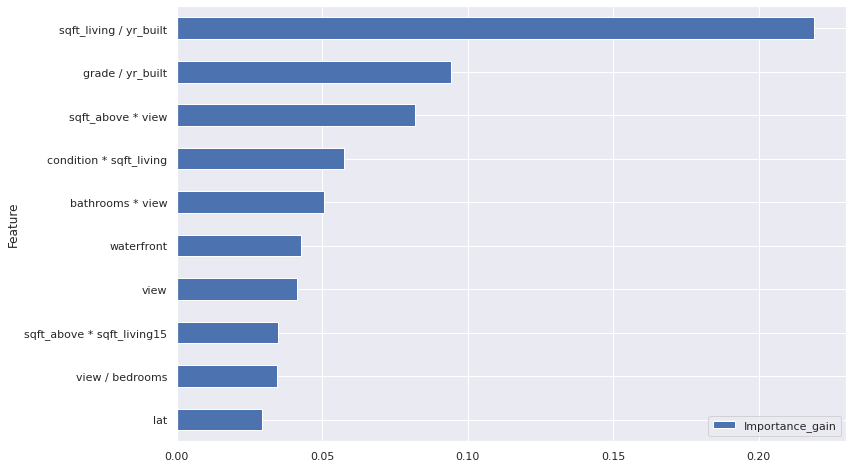

In [39]:
(df_imp
 .set_index('Feature')
 .nlargest(10,'Importance_gain')
 .plot
 .barh(figsize=(12,8))
 .invert_yaxis()
)

# Feature selection using feature importances

In [40]:
cols_zero_imp = df_imp.query("Importance_gain == 0.0")['Feature'].to_list()
len(cols_zero_imp), cols_zero_imp[:5]

(54,
 ['age_after_renovation_cat',
  'age_after_renovation_sq',
  'age_cat',
  'bathrooms',
  'bathrooms_sq'])

In [41]:
features2 = [i for i in features if i not in cols_zero_imp]
len(features2)

195

In [42]:
%%time
params_xgb = dict(
    n_jobs=-1, 
    random_state=SEED,
    objective='reg:squarederror',
    n_estimators=1200,
    max_depth=3,
    reg_alpha=1,
    reg_lambda=5,
    subsample=1,
    gamma=0,
    min_child_weight=1,
    colsample_bytree=1,
    learning_rate=0.1
    )

# log transform target
ytrain_log1p = np.log1p(ytrain)

model = xgboost.XGBRegressor(**params_xgb)
model.fit(df_Xtrain[features2], ytrain_log1p)

ypreds_log1p = model.predict(df_Xtest[features2])
ypreds = np.expm1(ypreds_log1p)

print('ytest:', ytest[:3])
print('ypreds: ', ypreds[:3])
print_regr_eval(ytest,ypreds,len(features2))

ytest: [285000. 239950. 460000.]
ypreds:  [331145.66 221523.1  558419.9 ]

             RMSE : 109,822.27
Explained Variance: 0.911361
         R-Squared: 0.910507
Adjusted R-squared: 0.906301


CPU times: user 3min 50s, sys: 483 ms, total: 3min 50s
Wall time: 2min 2s


# Time Taken

In [43]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

Time taken to run whole notebook: 0 hr 7 min 54 secs
